In [1]:
from qiskit import IBMQ

# Load Account and Choose Backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmqx2'
backend = provider.get_backend(name) # ibmq_16_melbourne, ibmq_vigo, ibmq_london, ibmq_burlington, ibmq_essex, ibmqx2, ibmq_ourense

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import warnings
import sys
sys.path.insert(1, '../Scripts')
from expfuncs import *
warnings.filterwarnings('ignore')

interested_qubits = [4,3,2,1]
itr = 32
QDT_correlated = False
noise_file_address = 'Noise4Q/'
file_address = 'T14Q/'
# all_methods_data(interested_qubits,backend, itr, QDT_correlated, file_address = noise_file_address)

In [ ]:
#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Generate RB circuits (2Q RB)
#number of qubits
#nQ=2
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1,2,3,4]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 16
#Default pattern
rb_opts['rb_pattern'] = [[1,2],[3,4]]

with open(file_address + 'RBparams.csv', newline='',mode='w') as sgr:
    count_writer = csv.writer(sgr, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    count_writer.writerow(['nseeds', rb_opts['nseeds']])
    arr = np.array(['length_vector'])
    count_writer.writerow(np.append(arr, rb_opts['length_vector']))

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)
print(len(rb_circs))
rb_circs[0][0].draw(output='mpl')

In [ ]:
circs = []
name_prefix = []
name_suffix = []
for i in range(rb_opts['nseeds']):
    n2 = 'seed'+str(i)
    name_suffix.append(n2)
for j in range(len(rb_opts['length_vector'])):
    n1 = 'len'+str(rb_opts['length_vector'][j])
    name_prefix.append(n1)
    
for n1 in name_prefix:
    for n2 in name_suffix:
        circs.append(rb_circs[i][j].copy(n1+n2))

In [ ]:
from qiskit import Aer,QuantumCircuit,transpile,execute,QuantumRegister
from qiskit.tools.monitor import job_monitor

# backend = Aer.get_backend("qasm_simulator")
shots = 8192
job = execute(circs, backend, shots=shots)
job_monitor(job)
res = job.result()
for length in name_prefix:
    print(length)
    for seed in name_suffix:
        print(seed)
        circ_name = length+seed
        with open(file_address + circ_name + '.csv',newline='', mode='w') as sgr:
            count_writer = csv.writer(sgr, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            for key, val in res.get_counts(circ_name).items():
                count_writer.writerow([key,val])

In [3]:
# Create Filters
# Run R file first!
our_filter, qiskit_filter, QDT_filter, SB_filter = create_filters(interested_qubits,QDT_correlated, show_denoised = False, from_file=True, file_address = noise_file_address)

Standard Bayesian filter
Our Filter
Qiskit filter
QDT filter


In [4]:
# Read RB paramsters
with open(file_address + 'RBparams.csv', mode='r') as sgm:
    reader = csv.reader(sgm)
    rb_params = {}
    for row in reader:
        if row[0] == 'nseeds':
            rb_params[row[0]] = int(row[1])
        if row[0] == 'length_vector':
            rb_params[row[0]] = []
            for i in range(1,len(row)):
                rb_params[row[0]].append(int(row[i]))
rb_params

{'nseeds': 16, 'length_vector': [1, 2, 3, 4]}

In [13]:
#Read RB data
import pandas as pd
df = pd.DataFrame({'Length':[], 'Seed':[], 'Probability':[], 'Method':[]})
for length in rb_params['length_vector']:
    for seed in range(rb_params['nseeds']):
        circ_name = 'len{}seed{}'.format(length,seed)
        with open(file_address + circ_name + '.csv', mode='r') as sgm:
            reader = csv.reader(sgm)
            real_counts = {}
            for row in reader:
                if (len(row)> 0):
                    real_counts[row[0]] = int(row[1])
        #print(real_counts)
        mean_counts = our_filter.filter_mean(real_counts)
        mode_counts = our_filter.filter_mode(real_counts)
        qis_counts = qiskit_filter.apply(real_counts)
        QDT_counts = QDT_filter.filter(real_counts)
        sbmean_counts = SB_filter.filter_mean(real_counts)
        sbmode_counts = SB_filter.filter_mode(real_counts)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': real_counts['0000']/8192, 'Method': 'Real'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': mean_counts['0000']/8192, 'Method': 'Con. Mean'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': mode_counts['0000']/8192, 'Method': 'Con. MAP'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': sbmean_counts['0000']/8192, 'Method': 'Stand. Mean'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': sbmode_counts['0000']/8192, 'Method': 'Stand. MAP'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': qis_counts['0000']/8192, 'Method': 'Qiskit'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': QDT_counts['0000']/8192, 'Method': 'QDT'}, ignore_index=True)
#df

Length 1


<Figure size 2250x900 with 0 Axes>

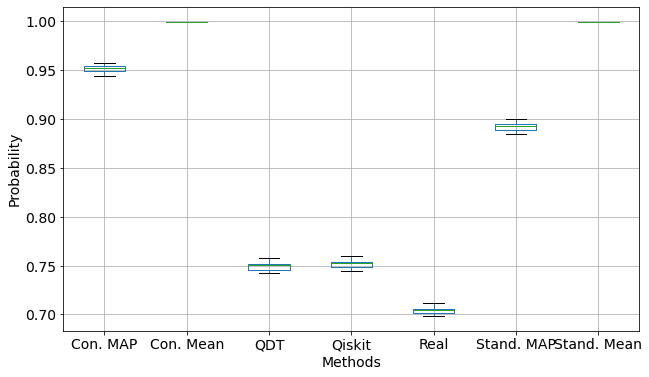

Length 2


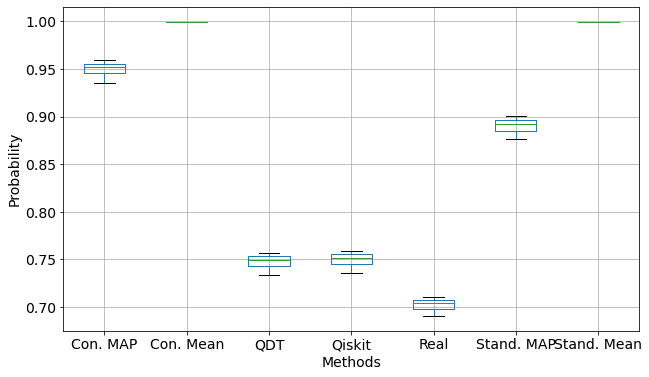

Length 3


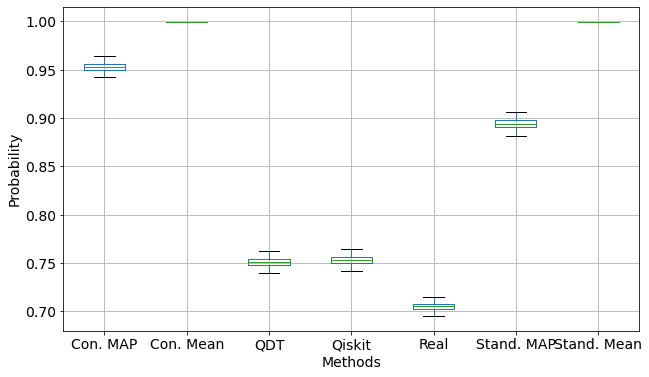

Length 4


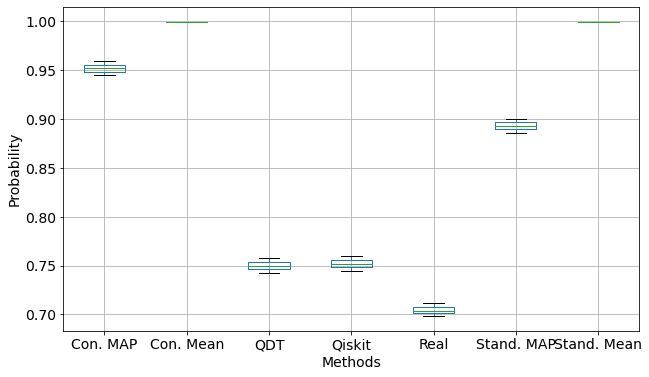

In [18]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=150, facecolor='w', edgecolor='k')
for length in rb_params['length_vector']:
    print('Length {}'.format(length))
    sub_df = df.loc[df['Length'] == length]
    ax = sub_df.drop(['Seed'], axis = 1).boxplot(column = 'Probability', by = 'Method',  figsize=(10,6),  fontsize=14)
    ax.set_xlabel('Methods',  fontsize=14)
    ax.set_ylabel('Probability',  fontsize=14)
    ax.set_title('')
    plt.suptitle('')
    plt.savefig(file_address + 'boxplot-len{}.jpg'.format(length))
    plt.show()

In [ ]:
df